#**Load the data**

In [127]:
from google.colab import drive
drive.mount('/content/drive')
!git clone https://github.com/shivansh-kaushal/Helmet-Non-Helmet-dataset-zip-files.git

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'Helmet-Non-Helmet-dataset-zip-files' already exists and is not an empty directory.


In [128]:
import zipfile
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [129]:

helmet_zip_path = '/content/Helmet-Non-Helmet-dataset-zip-files/Helmet_.zip'
non_helmet_zip_path = '/content/Helmet-Non-Helmet-dataset-zip-files/nohelmet.zip'
with zipfile.ZipFile(helmet_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/helmet')

with zipfile.ZipFile(non_helmet_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/non_helmet')

In [130]:
helmet_path = '/content/helmet'
non_helmet_path = '/content/non_helmet'
cleaned_helmet_path = '/content/cleaned_helmet'
cleaned_non_helmet_path = '/content/cleaned_non_helmet'

In [131]:
os.makedirs(cleaned_helmet_path, exist_ok=True)
os.makedirs(cleaned_non_helmet_path, exist_ok=True)

#**Image preprocessing**

In [132]:
def normalize_and_rename_images(source_dir, dest_dir, label):
    for filename in os.listdir(source_dir):
        if filename.lower().endswith(('.jpg', '.jpeg')):
            img_path = os.path.join(source_dir, filename)
            img = cv2.imread(img_path)

            if filename.lower().endswith('.jpeg'):
                filename = filename.replace('.jpeg', '.jpg')
            img = cv2.resize(img, (128, 128))

            dest_img_path = os.path.join(dest_dir, filename)
            cv2.imwrite(dest_img_path, img)

normalize_and_rename_images(helmet_path, cleaned_helmet_path, 'helmet')
normalize_and_rename_images(non_helmet_path, cleaned_non_helmet_path, 'non_helmet')

In [133]:
def load_images_and_labels(helmet_dir, non_helmet_dir):
    images = []
    labels = []

    for filename in os.listdir(helmet_dir):
        img_path = os.path.join(helmet_dir, filename)
        img = cv2.imread(img_path)
        img = img.astype('float32') / 255.0
        images.append(img)
        labels.append(0)


    for filename in os.listdir(non_helmet_dir):
        img_path = os.path.join(non_helmet_dir, filename)
        img = cv2.imread(img_path)
        img = img.astype('float32') / 255.0
        images.append(img)
        labels.append(1)

    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(cleaned_helmet_path, cleaned_non_helmet_path)

#**Split the data into train and test**

In [134]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [135]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)


In [136]:
def count_labels(dataset):
    label_counts = {0: 0, 1: 0}
    for images, labels in dataset:
        unique_labels, counts = np.unique(labels.numpy(), return_counts=True)
        for label, count in zip(unique_labels, counts):
            label_counts[label] += count
    return label_counts

train_label_counts = count_labels(train_dataset)
test_label_counts = count_labels(test_dataset)

print(f"Training label counts: {train_label_counts}")
print(f"Testing label counts: {test_label_counts}")

Training label counts: {0: 125, 1: 127}
Testing label counts: {0: 32, 1: 31}


Training Dataset Samples:


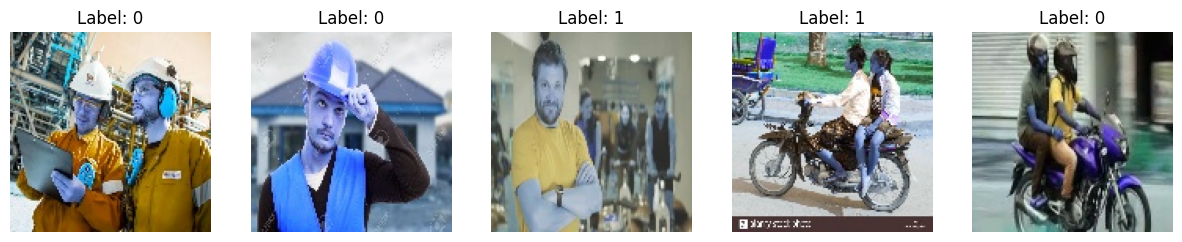

Testing Dataset Samples:


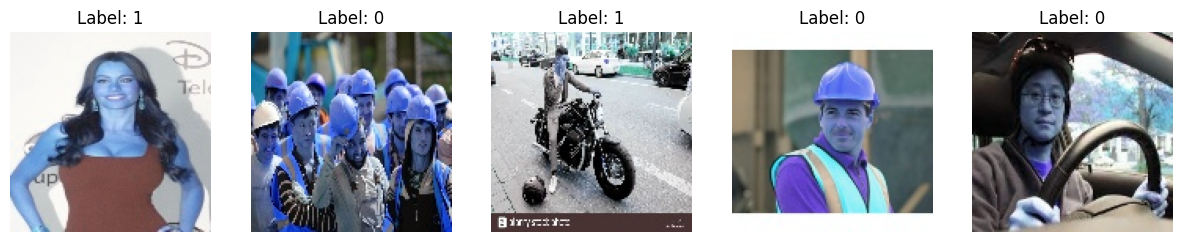

In [137]:

def visualize_dataset(dataset, num_samples=5):
    plt.figure(figsize=(15, 5))
    for images, labels in dataset.take(1):
        for i in range(min(num_samples, len(images))):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(f'Label: {labels[i].numpy()}')
            plt.axis('off')
        plt.show()
        break

print("Training Dataset Samples:")
visualize_dataset(train_dataset, num_samples=5)


print("Testing Dataset Samples:")
visualize_dataset(test_dataset, num_samples=5)

#**Model Developement**

In [138]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [139]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=17
)

Epoch 1/17
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 523ms/step - accuracy: 0.5742 - loss: 1.9978 - val_accuracy: 0.5079 - val_loss: 0.6959
Epoch 2/17
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4526 - loss: 0.7015 - val_accuracy: 0.5079 - val_loss: 0.6948
Epoch 3/17
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5289 - loss: 0.6895 - val_accuracy: 0.5079 - val_loss: 0.6909
Epoch 4/17
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5224 - loss: 0.6916 - val_accuracy: 0.4762 - val_loss: 0.6975
Epoch 5/17
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5361 - loss: 0.6790 - val_accuracy: 0.5238 - val_loss: 0.7083
Epoch 6/17
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6303 - loss: 0.6563 - val_accuracy: 0.5079 - val_loss: 0.7159
Epoch 7/17
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6387 - loss: 0.6518 - val_accuracy: 0.3651 - val_loss: 0.7258
Epoch 8/17
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5691 - loss: 0.6601 - val_accuracy: 0.4921 - val_loss: 0.7179

#**Model Evaluation**

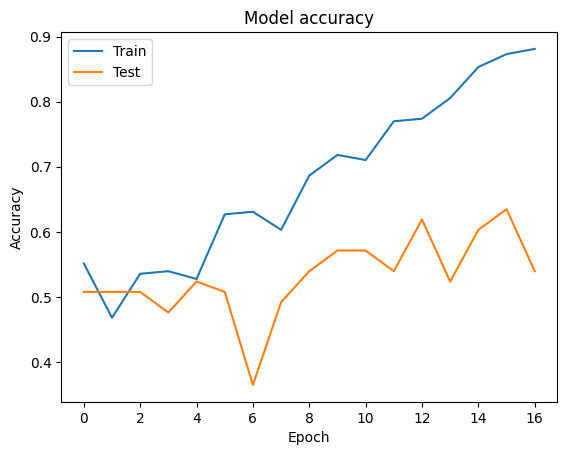

In [140]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


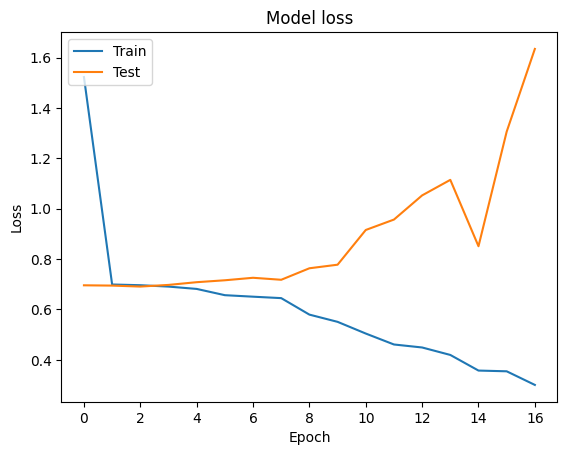

In [141]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [142]:


y_true = []
y_pred = []


for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)


y_true = np.array(y_true)
y_pred = np.array(y_pred)

test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Helmet', 'No Helmet']))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5160 - loss: 1.6753
Test Loss: 1.6347123384475708
Test Accuracy: 0.5396825671195984
Classification Report:
              precision    recall  f1-score   support

      Helmet       0.56      0.47      0.51        32
   No Helmet       0.53      0.61      0.57        31

    accuracy                           0.54        63
   macro avg       0.54      0.54      0.54        63
weighted avg       0.54      0.54      0.54        63



In [143]:
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Confusion Matrix:
[[15 17]
 [12 19]]


#**Model Fine tuning**

In [144]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32)

model.fit(train_generator, validation_data=test_generator, epochs=50)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5604 - loss: 6.3401 - val_accuracy: 0.5079 - val_loss: 0.6930
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4663 - loss: 0.6953 - val_accuracy: 0.5079 - val_loss: 0.6930
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5249 - loss: 0.6931 - val_accuracy: 0.5079 - val_loss: 0.6930
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4721 - loss: 0.6935 - val_accuracy: 0.4921 - val_loss: 0.6932
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5118 - loss: 0.6931 - val_accuracy: 0.4921 - val_loss: 0.6932
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5100 - loss: 0.6931 - val_accuracy: 0.4921 - val_loss: 0.6932
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5472 - loss: 0.6927 - val_accuracy: 0.4921 - val_loss: 0.6934
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5135 - loss: 0.6929 - val_accuracy: 0.4921 - val_loss: 0.6934
Epoch 9/50


In [145]:
model.add(tf.keras.layers.Dropout(0.5))

In [146]:


early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=22, callbacks=[early_stopping])


Epoch 1/22
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5917 - loss: 0.6851 - val_accuracy: 0.6508 - val_loss: 0.6639
Epoch 2/22
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6942 - loss: 0.5873 - val_accuracy: 0.5873 - val_loss: 0.8615
Epoch 3/22
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6402 - loss: 0.6409 - val_accuracy: 0.6825 - val_loss: 0.6318
Epoch 4/22
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8358 - loss: 0.5120 - val_accuracy: 0.5714 - val_loss: 0.8635
Epoch 5/22
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7885 - loss: 0.4480 - val_accuracy: 0.6032 - val_loss: 0.9470
Epoch 6/22
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8318 - loss: 0.3897 - val_accuracy: 0.6349 - val_loss: 0.9990
Epoch 7/22
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8431 - loss: 0.3478 - val_accuracy: 0.6349 - val_loss: 0.7370
Epoch 8/22
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8736 - loss: 0.3353 - val_accuracy: 0.6667 - val_loss: 0.9731


#**Final Evaluation**

In [147]:

test_loss, test_acc = model.evaluate(test_dataset)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6319 - loss: 0.9814
Test Loss: 0.9730744361877441
Test Accuracy: 0.6666666865348816


In [148]:

model.save('/content/helmet_classifier_model.h5')